# Machine Learning (COSC 522)
## Project 4

In [1]:
# Import Jupyter Widgets
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display
# Clone the repository if you're in Google Collab
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
def mount_and_change_dir(is_collab: bool = False):
    # Set working directory
    project_path = '/content/drive/MyDrive/Projects/UTK/COSC522'
    os.chdir(project_path)
    print(os.listdir(project_path))
       
print("Are you on Google Collab?")
btn = widgets.Button(description="Yes")
btn.on_click(mount_and_change_dir)
display(btn)

Are you on Google Collab?


Button(description='Yes', style=ButtonStyle())

## Initializations

In [2]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ['png']

import numpy as np
import matplotlib.pyplot as plt
from time import time
from pprint import pprint
import seaborn as sns
from scipy.stats import uniform, gaussian_kde, norm
from typing import *
from tqdm.notebook import tqdm

from custom_libs import ColorizedLogger

sns.set_style('darkgrid')

logger = ColorizedLogger('Project4', 'yellow')

### Load Models

In [3]:
# Located in <project root>/custom_libs/Project4
import custom_libs.Project4.models as p4_models
import custom_libs.Project4.nielsens_model as n_model

### Load Plotting Functions

In [4]:
def plot_results(losses, accuracies, subsample=100):
    losses_ = losses[::subsample]
    losses_ = list(zip(*losses_))    
    loss_names = []    
    loss_values= []

    for loss in losses_:
        loss_name, values = list(zip(*loss))
        loss_names.append(loss_name[0])
        loss_values.append(values)   
    
    accuracies_ = accuracies[::subsample]
    x = np.arange(1, len(accuracies_)+1)
    
    
    fig, ax = plt.subplots(1, len(loss_names)+1, figsize=(11, 4))
    try:
        ax[0].plot(x, accuracies_)
        ax[0].set_title('accuracies')
        xticks = ax[0].get_xticks().tolist()
        ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
        ax[0].set_xticklabels([int(xtick*subsample) for xtick in xticks])
    except Exception:
        print("skipping accuracies")
    for ind, (name, loss) in enumerate(zip(loss_names, loss_values)):
        try:
            ax[ind+1].plot(x, loss)
            ax[ind+1].set_title(name)
            xticks = ax[ind+1].get_xticks().tolist()
            ax[ind+1].set_xticklabels([int(xtick*subsample) for xtick in xticks])
        except Exception:
            print("skipping ", name)
        

### Load the two datasets and Preprocess them

In [5]:
# Located in <project root>/custom_libs/Project4
import custom_libs.Project4.data_loader as dl

In [6]:
# Create a Data Loader
datasets = ['xor', 'mnist']
data_loader = dl.DataLoader(datasets=datasets, data_folder='data')

In [7]:
# Get the two datasets
datasets = data_loader.get_datasets()
xor_data = datasets['xor']
mnist_tr, mnist_te, mnist_val = datasets['mnist']
print("xor_data\n", xor_data)

xor_data
 [[0 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 0]]


In [8]:
# Normalize and standarize them
# xor
xor_data_norm = data_loader.normalize_(xor_data)[0]
xor_data_stand = data_loader.standarize_(xor_data)[0]
print("xor_data_norm\n", xor_data_norm)
print("xor_data_stand\n", xor_data_stand)
# mnist
mnist_tr_norm, mnist_te_norm, mnist_val_norm = data_loader.normalize_(mnist_tr, 
                                                                      mnist_te,
                                                                      mnist_val)
mnist_tr_stand, mnist_te_stand, mnist_val_stand = data_loader.standarize_(mnist_tr, 
                                                                          mnist_te,
                                                                          mnist_val)

xor_data_norm
 [[-0.5 -0.5  0. ]
 [-0.5  0.5  1. ]
 [ 0.5 -0.5  1. ]
 [ 0.5  0.5  0. ]]
xor_data_stand
 [[-1. -1.  0.]
 [-1.  1.  1.]
 [ 1. -1.  1.]
 [ 1.  1.  0.]]


In [94]:
# One Hot Encode the target values
# xor
xor_y_one_hot = data_loader.one_hot_encode_last(xor_data)
print("XOR Y one hot encoded\n", xor_y_one_hot)
# Mnist
mnist_tr_y_one_hot = data_loader.one_hot_encode_last(mnist_tr)
mnist_te_y_one_hot = data_loader.one_hot_encode_last(mnist_te)
mnist_val_y_one_hot = data_loader.one_hot_encode_last(mnist_val)

XOR Y one hot encoded
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


## Function that trains the Model and plots results

In [104]:
def train_and_plot(dataset, targets, hidden_layers, activations, loss_functions, lr, momentum,
                   batch_size, early_stopping, max_epochs, regularization_param, shuffle, 
                   seed, debug, subsample=10):
    n_units = [int(dataset.shape[1]-1), *hidden_layers, int(dataset[:, -1].max()+1)]
    # Create Model
    mlp = p4_models.MultiLayerPerceptron(units=n_units, activations=activations, 
                                         loss_functions=loss_functions, seed=seed)
    # Train
    accuracies, losses = mlp.train(data=dataset, one_hot_y=targets,
                                   batch_size=batch_size, lr=lr, momentum=momentum,
                                   shuffle=shuffle, max_epochs=max_epochs, 
                                   early_stopping=early_stopping,
                                   regularization_param=regularization_param,
                                   debug=debug)
    # Plot
    plot_results(accuracies=accuracies, losses=losses, subsample=subsample)

## XOR Dataset

### My Code

2021-10-30 03:28:45 Project4 Models INFO     Units per Layer: [2, 4, 2]
2021-10-30 03:28:45 Project4 Models INFO     Shapes of biases: [(4, 1), (2, 1)]
2021-10-30 03:28:45 Project4 Models INFO     Shapes of weights: [(4, 2), (2, 4)]
2021-10-30 03:28:45 Project4 Models INFO     Epoch: 50
2021-10-30 03:28:45 Project4 Models INFO       mse Loss: 0.26813
2021-10-30 03:28:45 Project4 Models INFO       cross_entropy Loss: 0.71428
2021-10-30 03:28:45 Project4 Models INFO       Accuracy on training data: 4/4
2021-10-30 03:28:45 Project4 Models INFO     Epoch: 100
2021-10-30 03:28:45 Project4 Models INFO       mse Loss: 0.26899
2021-10-30 03:28:45 Project4 Models INFO       cross_entropy Loss: 0.72337
2021-10-30 03:28:45 Project4 Models INFO       Accuracy on training data: 4/4
2021-10-30 03:28:45 Project4 Models INFO     Epoch: 150
2021-10-30 03:28:45 Project4 Models INFO       mse Loss: 0.27320
2021-10-30 03:28:45 Project4 Models INFO       cross_entropy Loss: 0.73347
2021-10-30 03:28:45 Proj

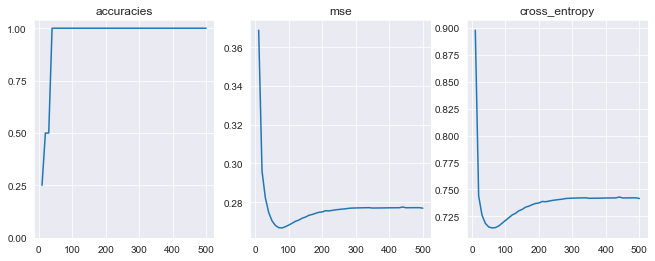

In [101]:
hidden_layers = [4]
activations = ["relu", "softmax"]
loss_functions = ['mse', 'cross_entropy']
lr = 0.1
momentum = 0.7
regularization_param = 0.037
batch_size = 1
max_epochs = 500
shuffle = False
early_stopping = None#{"accuracy": -1, "loss": -10, 'wait': 10}
seed = 3
debug = {'epochs': max_epochs/10, 'batches': 10**10, 
         'ff': False, 'bp': False, 'w': False, 'metrics': False}

# train_and_plot(xor_data.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
#                loss_functions, lr, batch_size, 
#                max_epochs, shuffle, seed, debug)
# train_and_plot(xor_data_norm.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
#                loss_functions, lr, batch_size, 
#                max_epochs, shuffle, seed, debug)
train_and_plot(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
               loss_functions, lr, momentum, batch_size, early_stopping,
               max_epochs, regularization_param, shuffle, seed, debug, subsample=10)

## Task 2

2021-10-30 03:29:22 Project4 Models INFO     Units per Layer: [784, 32, 64, 32, 10]
2021-10-30 03:29:22 Project4 Models INFO     Shapes of biases: [(32, 1), (64, 1), (32, 1), (10, 1)]
2021-10-30 03:29:22 Project4 Models INFO     Shapes of weights: [(32, 784), (64, 32), (32, 64), (10, 32)]
2021-10-30 03:29:22 Project4 Models INFO     Epoch: 1
2021-10-30 03:29:43 Project4 Models INFO       mse Loss: 0.02525
2021-10-30 03:29:43 Project4 Models INFO       cross_entropy Loss: 0.03020
2021-10-30 03:29:43 Project4 Models INFO       Accuracy on training data: 616/5000
2021-10-30 03:29:43 Project4 Models INFO     Epoch: 2
2021-10-30 03:29:59 Project4 Models INFO       mse Loss: 0.02053
2021-10-30 03:29:59 Project4 Models INFO       cross_entropy Loss: 0.02541
2021-10-30 03:29:59 Project4 Models INFO       Accuracy on training data: 650/5000
2021-10-30 03:29:59 Project4 Models INFO     Epoch: 3
2021-10-30 03:30:15 Project4 Models INFO       mse Loss: 0.01678
2021-10-30 03:30:15 Project4 Models I

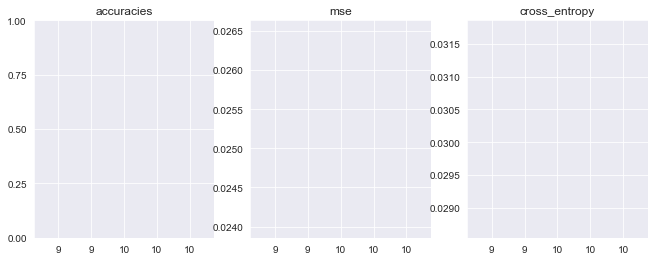

In [103]:
# mnist_tr_norm, mnist_te_norm, mnist_val_stand
hidden_layers = [32, 64, 32]
# activations = ["relu", "relu", "relu", "softmax"]
activations = ["sigmoid", "sigmoid", "sigmoid", "softmax"]
loss_functions = ['mse', 'cross_entropy']
lr = 0.5
batch_size = 15
max_epochs = 15
regularization_param = 0.01
early_stopping = {"accuracy": 30, "loss": -10, 'wait': 3}
shuffle = True
seed = 50
debug = {'epochs': 1, 'batches': 10**10, 
         'ff': False, 'bp': False, 'w': False, 'metrics': False}

train_and_plot(mnist_val_stand.copy(), mnist_val_y_one_hot.copy(), hidden_layers, activations, 
               loss_functions, lr, batch_size, early_stopping,
               max_epochs, regularization_param, shuffle, seed, debug, subsample=10)

In [ ]:
print(accuracies, losses)

plot_results(losses, accuracies, 1)

## Task 3